#### 앞서 MMDetection을 사용하기 위해서는 MMDetection이 읽을 수 있도록 데이터를 정렬시켜주어야한다고 했다. <br>본 코드는 특정 상태(Custom)로 데이터가 정렬되어있을 때, MMDetection에 입력할 수 있도록 데이터를 정렬시켜주는 방법에 대한 코드이다.

### MMDetection 설치

In [1]:
import torch
torch.__version__

'1.12.1+cu113'

In [2]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
!git clone https://github.com/open-mmlab/mmdetection.git
# mmdetection git
!cd mmdetection; python setup.py install
# 환경 세팅

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
     |████████████████████████████████| 40.6 MB 7.2 MB/s 
     |████████████████████████████████| 190 kB 13.7 MB/s 
Cloning into 'mmdetection'...
remote: Enumerating objects: 31148, done.
remote: Counting objects: 100% (1678/1678), done.
remote: Compressing objects: 100% (874/874), done.
remote: Total 31148 (delta 876), reused 1373 (delta 776), pack-reused 29470
Receiving objects: 100% (31148/31148), 40.93 MiB | 17.06 MiB/s, done.
Resolving deltas: 100% (21979/21979), done.
running install
running bdist_egg
running egg_info
creating mmdet.egg-info
writing mmdet.egg-info/PKG-INFO
writing dependency_links to mmdet.egg-info/dependency_links.txt
writing requirements to mmdet.egg-info/requires.txt
writing top-level names to mmdet.egg-info/top_level.txt
writing manifest file 'mmdet.egg-info/SOURCES.txt'
read

* 아래 코드를 실행하기 전 : 런 타임 → 런 타임 다시 시작

In [1]:
from mmdet.apis import init_detector, inference_detector
import mmcv

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* MMDetection Package를 사용하려면 Config file에 대한 이해가 필요로 한다.

In [3]:
from IPython.display import Image

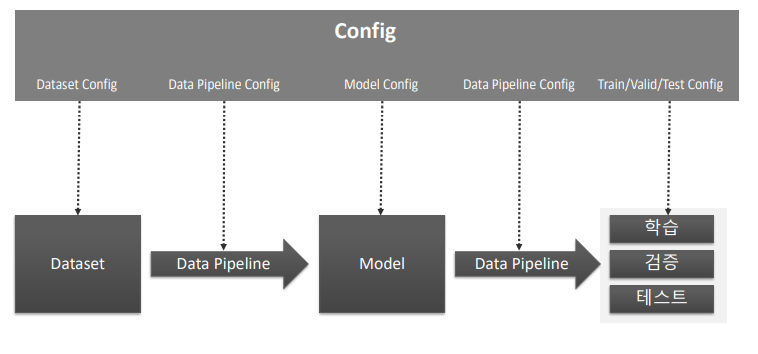

In [4]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/04/cfg.png')

* 위의 사진에서 보듯, 우리가 MMDetection을 사용하려면 pipeline에 맞게 Dataset을 변형시켜주어야한다. 
<br>: Dataset Config을 잘 다루어야한다. 변환 클래스를 통해서 변환하여 사용할 수 있음.(디렉토리의 구조를 맞춰줘야한다.)
* 대표적인 학습용 데이터의 특성
<br>[image와 annotation(객체의 위치 좌표(bbox) 등)]
  - PASCAL VOC : image당 1개의 annotation의 파일이 있다.
  - MS COCO : 모든 이미지에 1개의 annotation 파일이 있다.
  <br>▷ COCO 스타일을 더 선호한다. 리스트안에 모든 정보가 전부 담겨져 있는 형태.하지만 그냥 Custom Dataset 포맷으로 변경하는 것이 가장 편하다.

#### Custom Dataset(Middle format) 포맷
  - 모든 이미지에 대한 annotation 정보를 하나의 파일 list로 가짐.
  - 개별원소는 dict형태 dict1개는 1개의 이미지에 대한 annotation
  - 1개의 이미지는 여러개의 box, label 정보
  - bbox는 2차원, label은 1차원 array로 구성

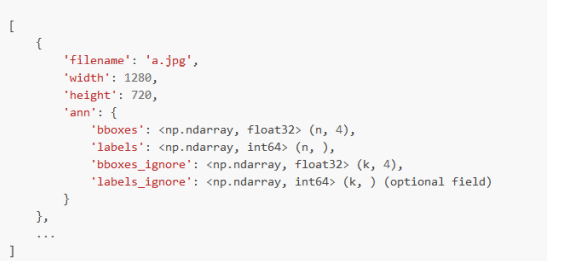

In [5]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/04/cfm.png')

### KITTI Dataset 다운로드
* 작은 용량의 KITTI Dataset을 다운로드하고 /content 밑에 압축 해제

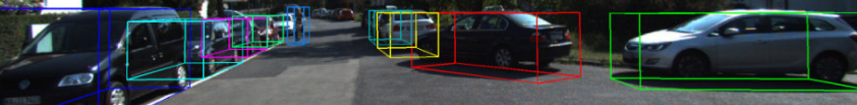

In [6]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/04/ktti.png')

In [7]:
!wget https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
# 이미지 다운받고
!unzip kitti_tiny.zip > /dev/null
# zip 풀기

--2022-08-31 06:12:26--  https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
Resolving download.openmmlab.com (download.openmmlab.com)... 161.117.242.73
Connecting to download.openmmlab.com (download.openmmlab.com)|161.117.242.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918271 (6.6M) [application/zip]
Saving to: ‘kitti_tiny.zip’

kitti_tiny.zip      100%[===================>]   6.60M  32.8MB/s    in 0.2s    

2022-08-31 06:12:29 (32.8 MB/s) - ‘kitti_tiny.zip’ saved [6918271/6918271]



* 이미지 시각화

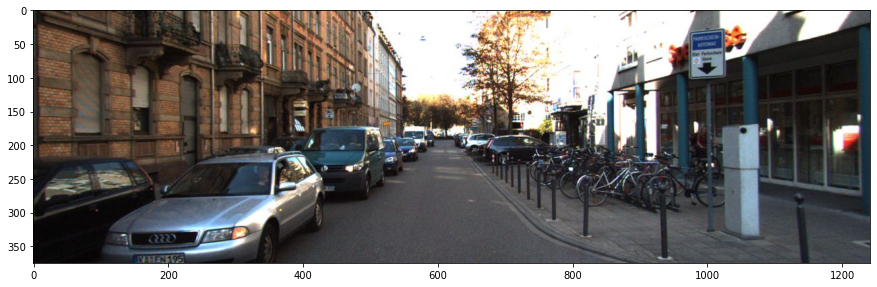

In [8]:
import matplotlib.pyplot as plt
import cv2

img = cv2.cvtColor(cv2.imread('/content/kitti_tiny/training/image_2/000068.jpeg'), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 10))
plt.imshow(img)

* kitty_tiny data 특징
<br> [폴더 구조]
    - training
      - image_2 : image 
      - label_2 : 객체, bbox 정보(annotation)
    - train.txt : train 파일 고유명(확장자 제외)
    - val.txt : valid 파일 고유명(확장자 제외)
<br> ▷ 우리는 이 format을 Custom Dataset format으로 변경해야한다.
    

### KITTI DATA FORMAT 확인
* 첫번째 컬럼은 해당 오브젝트의 클래스 명. 
* 5번째~8번째가 BOUNDING BOX 정보임. 좌상단(xmin, ymin), 우하단(xmax, ymax) 좌표 임. 
  <br>→ 위도, 경도, 고도 등의 데이터도 존재.

In [10]:
!cat /content/kitti_tiny/training/label_2/000068.txt
# 어떤 객체가 있는지 정보

Car 0.25 0 1.94 69.26 200.28 435.08 374.00 1.46 1.62 4.04 -3.00 1.79 6.98 1.55
Car 0.80 1 2.26 0.00 209.20 198.59 374.00 1.46 1.58 3.72 -5.44 1.85 6.22 1.56
Cyclist 0.97 0 2.34 1210.28 199.77 1241.00 374.00 1.55 0.57 1.73 4.04 1.69 3.57 -3.14
Car 0.00 2 1.68 478.18 187.68 549.54 249.43 1.57 1.60 3.99 -2.73 2.03 20.96 1.55
Car 0.00 1 1.66 530.03 187.79 573.10 226.09 1.52 1.54 3.68 -2.53 2.20 31.50 1.58
Van 0.00 1 1.63 547.61 171.12 584.05 212.41 2.47 1.98 5.81 -2.79 2.41 46.44 1.57
Car 0.00 1 -0.16 667.74 182.35 790.82 230.38 1.62 1.65 4.14 4.19 1.99 25.95 0.00
Car 0.00 2 -0.11 657.37 184.48 763.34 221.64 1.55 1.66 4.47 4.35 2.10 32.00 0.02
Car 0.00 1 -0.01 637.45 180.34 714.44 212.34 1.69 1.76 4.12 3.59 2.12 39.79 0.08
Van 0.00 1 1.61 572.52 175.02 596.26 199.95 2.13 1.91 6.40 -2.28 2.36 65.43 1.57
Van 0.00 1 1.77 380.78 167.69 523.29 288.56 1.95 1.75 4.63 -2.89 1.90 14.05 1.57
Cyclist 0.00 1 1.09 958.95 167.55 1036.88 254.43 1.68 0.53 1.96 7.95 1.59 14.95 1.57


### KITTI annotation 파일들의 리스트들을 가지는 파일 확인. 

In [11]:
!cat /content/kitti_tiny/train.txt
# 파일의 고유한 이름(확장자 제외)을 갖고 있다.

000000
000001
000002
000003
000004
000005
000006
000007
000008
000009
000010
000011
000012
000013
000014
000015
000016
000017
000018
000019
000020
000021
000022
000023
000024
000025
000026
000027
000028
000029
000030
000031
000032
000033
000034
000035
000036
000037
000038
000039
000040
000041
000042
000043
000044
000045
000046
000047
000048
000049


▷ 즉 현재 위의 데이터셋은 PASCAL VOC와 같이 image와 그에 해당하는 annotation 파일을 각각 갖고 있다. 이제 MMDetection에 맞게 변형할 것이다.

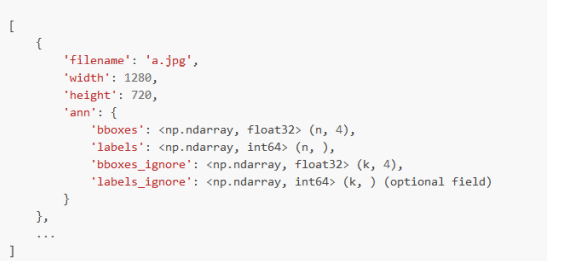

In [12]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/04/cfm.png')

### mmdetection의 annotation 포맷 변환. 해당 포맷은 텍스트로 변환하지 않음. 바로 메모리 상의 list로 생성됨.  
#### filename, width, height, ann을 Key로 가지는 Dictionary를 이미지 개수대로 가지는 list 생성. 
* filename: 이미지 파일명(디렉토리는 포함하지 않음)
* width: 이미지 너비
* height: 이미지 높이
* ann: bbounding box와 label에 대한 정보를 가지는 Dictionary
 - bboxes: 하나의 이미지에 있는 여러 Object 들의 numpy array. 4개의 좌표값(좌상단, 우하단)을 가지고, 해당 이미지에 n개의 Object들이 있을 경우 array의 shape는 (n, 4)
 - labels: 하나의 이미지에 있는 여러 Object들의 numpy array. shape는 (n, )
 - bboxes_ignore: 학습에 사용되지 않고 무시하는 bboxes. 무시하는 bboxes의 개수가 k개이면 shape는 (k, 4)
 - labels_ignore: 학습에 사용되지 않고 무시하는 labels. 무시하는 bboxes의 개수가 k개이면 shape는 (k,)

### kitti Dataset을 중립 데이터형태로 변환하여 메모리 로드
  - Middle 포맷으로 변환하는 방법

In [13]:
# 원본 kitti Dataset는 10개의 Class로 되어 있음. 'Car Van Truck Pedestrian Person_sitting Cyclist Tram Misc DontCare'
CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
# 다운 받은 데이터는 위의 class만 갖고 있음.
cat2label = {k:i for i, k in enumerate(CLASSES)}
# 우리는 위와 같은 코드를 사용하여 각각의 class가 숫자에 mapping되는 dic형태의 자료를 만든 것이다.
# class mapping dict 생성
print(cat2label)
cat2label['Car']

{'Car': 0, 'Truck': 1, 'Pedestrian': 2, 'Cyclist': 3}


0

In [14]:
image_list = mmcv.list_from_file('/content/kitti_tiny/train.txt')
# 확장자를 제외한 image 이름만 가진 파일을 load

In [15]:
image_list # 확장자를 제외한 train image 명

['000000',
 '000001',
 '000002',
 '000003',
 '000004',
 '000005',
 '000006',
 '000007',
 '000008',
 '000009',
 '000010',
 '000011',
 '000012',
 '000013',
 '000014',
 '000015',
 '000016',
 '000017',
 '000018',
 '000019',
 '000020',
 '000021',
 '000022',
 '000023',
 '000024',
 '000025',
 '000026',
 '000027',
 '000028',
 '000029',
 '000030',
 '000031',
 '000032',
 '000033',
 '000034',
 '000035',
 '000036',
 '000037',
 '000038',
 '000039',
 '000040',
 '000041',
 '000042',
 '000043',
 '000044',
 '000045',
 '000046',
 '000047',
 '000048',
 '000049']

- 아래 코드에서 사용할 예시

In [16]:
lines = mmcv.list_from_file('/content/kitti_tiny/training/label_2/000064.txt')
# 원래는 아래와 같이 객체명과 다양한 annotation 정보가 일렬로 하나의 이미지에 쭉 적혀있다.
# 공백으로 parsing해서 각각의 정보를 분리한 다음 필요한 정보만 가져오고 싶다.
# 위에서 말한 형식으로 바꾸고 싶다.
print(lines)

['Car 0.00 0 -1.70 657.65 179.93 709.86 219.92 1.38 1.49 3.32 2.65 1.65 26.82 -1.60', 'Car 0.00 0 -1.85 731.51 180.39 882.28 275.80 1.50 1.62 3.89 3.43 1.65 13.46 -1.60', 'Car 0.00 1 -1.83 715.18 175.63 762.77 203.90 1.44 1.56 3.96 6.91 1.61 39.17 -1.65', 'Truck 0.00 1 -2.01 816.58 59.74 1112.51 266.07 3.55 2.56 7.97 7.25 1.64 16.44 -1.60', 'DontCare -1 -1 -10 626.78 174.27 647.77 192.18 -1 -1 -1 -1000 -1000 -1000 -10', 'DontCare -1 -1 -10 546.19 168.97 554.01 177.09 -1 -1 -1 -1000 -1000 -1000 -10']


→ 객체와 그 객체의 좌표정보가 ','로 구분되어있다.

In [17]:
content = [line.strip().split(' ') for line in lines]
# lines에서 하나의 line(객체 정보)만 가져온다.(for문 앞까지)
# 가져온 하나의 정보를 공백을 기준으로 분리한다.
# 하나의 정보를 공백으로 분리한 것을 하나의 원소로 다시 리스트로 묶는다.
print(content)

[['Car', '0.00', '0', '-1.70', '657.65', '179.93', '709.86', '219.92', '1.38', '1.49', '3.32', '2.65', '1.65', '26.82', '-1.60'], ['Car', '0.00', '0', '-1.85', '731.51', '180.39', '882.28', '275.80', '1.50', '1.62', '3.89', '3.43', '1.65', '13.46', '-1.60'], ['Car', '0.00', '1', '-1.83', '715.18', '175.63', '762.77', '203.90', '1.44', '1.56', '3.96', '6.91', '1.61', '39.17', '-1.65'], ['Truck', '0.00', '1', '-2.01', '816.58', '59.74', '1112.51', '266.07', '3.55', '2.56', '7.97', '7.25', '1.64', '16.44', '-1.60'], ['DontCare', '-1', '-1', '-10', '626.78', '174.27', '647.77', '192.18', '-1', '-1', '-1', '-1000', '-1000', '-1000', '-10'], ['DontCare', '-1', '-1', '-10', '546.19', '168.97', '554.01', '177.09', '-1', '-1', '-1', '-1000', '-1000', '-1000', '-10']]


→ 위와 같이 하면 각 객체 별로 리스트 [ ]안에 묶이고 객체, 좌표의 형태로 입력이 구분이 된다.

In [18]:
bbox_names = [x[0] for x in content]
# 각 리스트에서 맨 앞에 있는 값. 즉, 객체의 이름만 가져온다.
print(bbox_names)

['Car', 'Car', 'Car', 'Truck', 'DontCare', 'DontCare']


→ 이름만 따로 filename으로 mapping 해야하기에 리스트에 담는다.

In [19]:
bboxes = [ [float(info) for info in x[4:8]] for x in content]
# 5번째부터 8번째의 값이 좌상단, 우하단의 좌표라고 했었다. 해당좌표만 가져온다.
print(bboxes) # bounding box 정보만 가져온다.

[[657.65, 179.93, 709.86, 219.92], [731.51, 180.39, 882.28, 275.8], [715.18, 175.63, 762.77, 203.9], [816.58, 59.74, 1112.51, 266.07], [626.78, 174.27, 647.77, 192.18], [546.19, 168.97, 554.01, 177.09]]


→ 우리가 현재 하는 Task는 객체 감지이기에 bbox를 만드는데 필요한 좌상단, 우하단 좌표만 가져온다.

In [20]:
image_list = mmcv.list_from_file('/content/kitti_tiny/train.txt')
# 확장자를 제외한 이미지이름 파일
print(image_list)

['000000', '000001', '000002', '000003', '000004', '000005', '000006', '000007', '000008', '000009', '000010', '000011', '000012', '000013', '000014', '000015', '000016', '000017', '000018', '000019', '000020', '000021', '000022', '000023', '000024', '000025', '000026', '000027', '000028', '000029', '000030', '000031', '000032', '000033', '000034', '000035', '000036', '000037', '000038', '000039', '000040', '000041', '000042', '000043', '000044', '000045', '000046', '000047', '000048', '000049']


### Custom Dataset 생성 순서

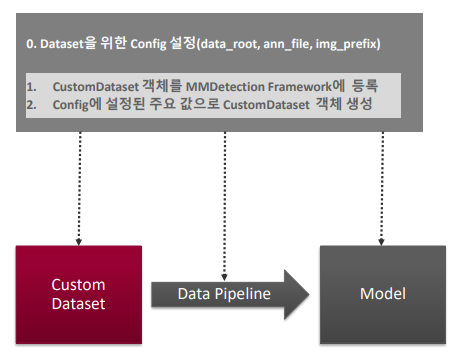

In [21]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/04/csd.png')

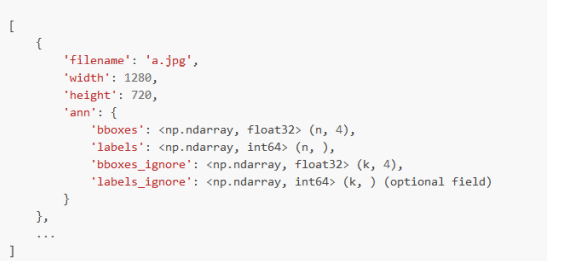

In [22]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/04/cfm.png')

▷ data_root, ann_file, img_prefix가 위와 같은 변환을 하는데에 굉장히 중요한 파라미터이다.
  - Dataset은 학습용 검증용 테스트용으로 각각 만들어져야한다. 위의 세가지의 파라미터로 이것을 mmdtection이 원하는 형식으로 변경할 것.

In [23]:
import copy
import os.path as osp
import cv2

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset


@DATASETS.register_module(force=True) 
# mmdetection framwork에 등록하는 것. : 기존의 dataloader를 재사용하면서 새로운 Custom Dataset을 이용하고자 하기에 등록이 필요.
#force=True를 입력하지 않으면 Dataset 재등록 불가. -> 수정해야할 수 있기에 True설정.

# 1번 작업 등록만 하면 config시에 mm framework 알아서 읽는다.  
# 2번 작업은 build_dataset을 할때 알아서 해준다.


class KittyTinyDataset(CustomDataset): 
  # CustomDataset을 상속 
  CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist') 
  # 우리가 사용할 데이터의 class 명을 입력 그러면 자동적으로 0, 1, 2, 3으로 class_id를 부여한다.
  # class변수.__init__가 없다.-> CustomDataset 인자를 그대로 사용하겠다. 
  
  # self.data_root: /content/kitti_tiny/ -> 우리가 들어가야할 데이터의 경로
  # self.ann_file: /content/kitti_tiny/train.txt -> annotaion이 존재하는 경로
  # self.img_prefix: /content/kitti_tiny/training/image_2 -> image가 존재하는 경로
  # ann_file: /content/kitti_tiny/train.txt -> 확장자명이 없는 이미지 이름
  # annotation에 대한 모든 파일명을 가지고 있는 텍스트 파일을 __init__(self, ann_file)로 입력 받고, 이 self.ann_file이 load_annotations()의 인자로 입력
  
  # -> 앞서 입력할 변수에 대한 내용 설명.

  def load_annotations(self, ann_file):
    print('##### self.data_root:', self.data_root, 'self.ann_file:', self.ann_file, 'self.img_prefix:', self.img_prefix)
    print('#### ann_file:', ann_file)

    cat2label = {k:i for i, k in enumerate(self.CLASSES)}
    # 위에서 연습한 대로 이렇게 코드를 입력하면 class_id와 숫자가 mapping되는 dict가 완성된다.

    image_list = mmcv.list_from_file(self.ann_file)
    # 확장자명이 없는 이미지 이름을 받아서 list로 만든다.

    data_infos = []
    # 포맷 데이터를 담을 list 객체
    # 위의 list에 이제 이름, width, height, ann{object별 정보}, 등을 입력하면 된다.

    for image_id in image_list:
      # image list : 확장자 없는 이미지 이름을 하나씩 순차적으로 가져온다.

      filename = '{0:}/{1:}.jpeg'.format(self.img_prefix, image_id)
      # self.img_prefix: /content/kitti_tiny/training/image_2 이기에 이미지의 절대 경로 + 이미지 이름이 된다. 
      # 이미지 한장 한장 접근하기 위해 이미지 경로를 불러온것.

      # 포맷에 file 절대경로는 필요없고 이름.jpg만 있으면 된다. 그런데 너비 높이를 가져와야해서 구해둔다.
      
      image = cv2.imread(filename)
      # 위의 경로의 이미지 load : 원본 이미지의 너비, 높이를 image를 직접 로드하여 구할 것이다.

      height, width = image.shape[:2]
      # 이미지의 height, width 가져오기
     
      # 개별 image의 annotation 정보 저장용 Dict 생성. key값 filename 에는 image의 파일명만 들어감(디렉토리는 제외)
      data_info = {'filename': str(image_id) + '.jpeg',
                   'width': width, 'height': height}
      # 위의 포맷과 동일하게 경로제외한 파일 이름
      # 너비
      # 높이 만 가져온다. 


#### 여기까지 하나의 이미지에 대한 작업 끝 ####
#### 이미지 안의 object의 annotation 작업 시작 ####

      # annotatoin 정보를 읽어와야한다.

      label_prefix = self.img_prefix.replace('image_2', 'label_2')
      # 경로는 동일하게 image가 아닌 label로 접근하면 annotation 파일에 접근할 수 있다. 

      lines = mmcv.list_from_file(osp.join(label_prefix, str(image_id)+'.txt'))
      # 이미지 annotation 경로 + txt를 새로운 경로로 하여 하나씩 읽는다.
      

      ## 위에서 연습한 코드 ###

      content = [line.strip().split(' ') for line in lines]
      # 위에서 가져온 object별 annotation 정보를 각각의 list로 묶는다.

      bbox_names = [x[0] for x in content]
      # 객체의 클래스명은 bbox_names로 따로 저장. : 첫번째가 class name
      
      bboxes = [ [float(info) for info in x[4:8]] for x in content]
      # annotation 정보 : 5번째부터 8번째가 bbox 정보
      
      # 저장할 list
      gt_bboxes = []
      gt_labels = []

      # 클래스명이 해당 사항이 없는 대상
      gt_bboxes_ignore = []
      gt_labels_ignore = []

      for bbox_name, bbox in zip(bbox_names, bboxes):
        # 만약 bbox_name이 클래스명에 해당 되면, gt_bboxes와 gt_labels에 추가,
        # 그렇지 않으면 gt_bboxes_ignore, gt_labels_ignore에 추가
        if bbox_name in cat2label:
          # class가 위에서 만든 class dict에 존재하면,
          gt_bboxes.append(bbox)
          # 추가한다.
          gt_labels.append(cat2label[bbox_name])
          # 또한 해당하는 label을 추가한다.
        else:
          # 그렇지않으면
          gt_bboxes_ignore.append(bbox)
          # 무시할 공간에 따로 저장한다.
          gt_labels_ignore.append(-1)
          
      # 위에서 작업한 내용을 차례대로 dict안에 저장하여 우리가 만들고 싶은 format으로 만든다.
      data_anno = {
          'bboxes': np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
          'labels': np.array(gt_labels, dtype=np.long),
          'bboxes_ignore': np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
          'labels_ignore': np.array(gt_labels_ignore, dtype=np.long)
      }


      # image에 대한 메타 정보를 가지는 data_info Dict에 'ann' key값으로 data_anno를 value로 저장. 
      data_info.update(ann=data_anno)

      # 전체 annotation 파일들에 대한 정보를 가지는 data_infos list에 data_info Dict를 추가
      data_infos.append(data_info)

    return data_infos

▷ 위의 내용을 이해하면 데이터에 맞게 MMdetection을 사용할 수 있다. 

In [24]:
### Config 설정하고 Pretrained 모델 load
config_file = '/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
# 경로를 찾아서 들어가 보면 첫번째 파일은 모델에 대한 내용이 dict로 들어가 있다. 

# Backbone, neck, rpn_head 등으로 구성되어있다.
# 처음보다 많이 발전 된 형태. FPN, ReNet 등.

# 두번째 파일은 데이터를 어떻게 할 것인지에 대해
# 세번째 파일은 optimizer, lr등이 있다.
# 네번째 파일은 hook(callback) check point 등에 대한 설정.

checkpoint_file = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'
# 사용할 가중치 load

In [25]:
!cd mmdetection; mkdir checkpoints
!wget -O /content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

--2022-08-31 06:24:18--  http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 161.117.242.73
Connecting to download.openmmlab.com (download.openmmlab.com)|161.117.242.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’

/content/mmdetectio 100%[===================>] 159.54M  49.6MB/s    in 3.4s    

2022-08-31 06:24:22 (46.7 MB/s) - ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’ saved [167287506/167287506]



In [26]:
from mmcv import Config

# dataset : dataset의 type, train/valid/test, data_root(ann_file, img_prefix, pipeline)
# model : backbone, neck, head
# schedule : optimizer, learning_rate, epoch
# run time : hook(callback)

cfg = Config.fromfile(config_file)
# 위에서 확인한 파일을 쭉 한번에 볼 수 있다.
# 데이터, num_classes 등을 변경해야할 것같다.
print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.

In [27]:
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정. 
# 위에서 확인해보면 알 수 있듯, 변경해줘야할 부분이 있다.
# dict 수정하듯이 하면된다.
cfg.dataset_type = 'KittyTinyDataset'
cfg.data_root = '/content/kitti_tiny/'
# 우리 데이터의 절대경로

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정. 
# config 작성
cfg.data.train.type = 'KittyTinyDataset'
cfg.data.train.data_root = '/content/kitti_tiny/'
cfg.data.train.ann_file = 'train.txt' 
# 나중에 위의 경로와 concat 따라서 '/'가 없어야한다.
cfg.data.train.img_prefix = 'training/image_2'

# config 작성
cfg.data.val.type = 'KittyTinyDataset'
cfg.data.val.data_root = '/content/kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

cfg.data.test.type = 'KittyTinyDataset'
cfg.data.test.data_root = '/content/kitti_tiny/'
cfg.data.test.ann_file = 'val.txt'
cfg.data.test.img_prefix = 'training/image_2'

# class의 갯수 수정. 
cfg.model.roi_head.bbox_head.num_classes = 4
# 우리는 4개의 class를 가짐

# pretrained 모델
cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'
# 다운로드 받은 파일, 상대경로로 설정함.

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정. 
cfg.work_dir = './tutorial_exps'


# 튜닝을 위해서 수정할 부분들.
# 학습율 변경 환경 파라미터 설정. 
cfg.optimizer.lr = 0.02 / 8 # gpu8개 -> 우리는 1개


cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# config 수행 시마다 policy값이 없어지는 bug로 인하여 설정 : 그냥 bug 때문에 설정.
cfg.lr_config.policy = 'step'

# 우리가 사용하는 데이터에 맞게 검증 지표 변경
cfg.evaluation.metric = 'mAP'
# 검증 시간 간격 설정
cfg.evaluation.interval = 12
# 체크포인트 저장 간격 지정
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_w

In [28]:
from mmdet.apis import set_random_seed

# data pipeline 가장 최적화된 것으로 설정되어있기에 수정하지 않는 편이 성능 향상에 좋다.
cfg.data.train.pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='LoadAnnotations', with_bbox=True),
            dict(type='Resize', img_scale=(1500, 900), keep_ratio=True),
            dict(type='RandomFlip', flip_ratio=0.5),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size_divisor=32),
            dict(type='DefaultFormatBundle'),
            dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
        ]

cfg.data.val.pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(1500, 900),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True), # 비율 유지
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True), # rgb로 변환하고 mean, std 등을 적용
                    dict(type='Pad', size_divisor=32),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]
  
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='Resize', img_scale=(1500, 900), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1500, 900),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]


cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device='cuda'


print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_w

### Config에서 설정한 Dataset과 Model, 동적 학습율, Pipeline 설정에 따라 모델 학습 수행. 

* train용 Dataset을 생성하고 이를 이용하여 학습 수행. 

In [29]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# train용 Dataset 생성. 
datasets = [build_dataset(cfg.data.train)]
# 위에서 만든 custom dataset

##### self.data_root: /content/kitti_tiny/ self.ann_file: /content/kitti_tiny/train.txt self.img_prefix: /content/kitti_tiny/training/image_2
#### ann_file: /content/kitti_tiny/train.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:120: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `in

In [30]:
datasets
# train 50개 등 데이터 셋 

[
 KittyTinyDataset Train dataset with number of images 50, and instance counts: 
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+
 | category | count | category  | count | category       | count | category    | count | category      | count |
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+
 | 0 [Car]  | 147   | 1 [Truck] | 7     | 2 [Pedestrian] | 23    | 3 [Cyclist] | 7     | -1 background | 0     |
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+]

In [31]:
datasets[0].CLASSES

('Car', 'Truck', 'Pedestrian', 'Cyclist')

In [32]:
# 모델과 config를 입력하여 detector model 정의
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

In [33]:
model.CLASSES = datasets[0].CLASSES

In [34]:
# 주의, config에 pretrained 모델 지정이 상대 경로로 설정됨 cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'
# 아래와 같이 %cd mmdetection 지정 필요. 
 
%cd mmdetection 
# mmdetection 경로 안으로 들어와서 실행

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# 로그 저장을 위한 경로 : 위에서 만들었음. 있으면 안만듬.

# 학습시작.
# epochs는 config의 runner 파라미터로 지정됨. 기본 12회 
train_detector(model, datasets, cfg, distributed=False, validate=True)

/content/mmdetection


2022-08-31 06:28:17,241 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:120: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by

##### self.data_root: /content/kitti_tiny/ self.ann_file: /content/kitti_tiny/val.txt self.img_prefix: /content/kitti_tiny/training/image_2
#### ann_file: /content/kitti_tiny/val.txt


2022-08-31 06:28:17,541 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([5, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([5]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([16, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([16]).
2022-08-31 06:28:17,547 - mmdet - INFO - Start running, host: root@214ca36db8a1, work_dir: /content/mmdetection/tutorial_exps
2022-08-31 06:28:17,549 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH  

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 9.0 task/s, elapsed: 3s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-08-31 06:31:05,418 - mmdet - INFO - 
+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 62  | 139  | 0.952  | 0.833 |
| Truck      | 3   | 21   | 1.000  | 0.667 |
| Pedestrian | 13  | 48   | 0.846  | 0.730 |
| Cyclist    | 7   | 49   | 0.429  | 0.058 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.572 |
+------------+-----+------+--------+-------+
2022-08-31 06:31:05,421 - mmdet - INFO - Epoch(val) [12][25]	AP50: 0.5720, mAP: 0.5721


### 학습된 model을 이용하여 inference 수행. 

In [35]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# BGR Image 사용 
img = cv2.imread('/content/kitti_tiny/training/image_2/000068.jpeg')

model.cfg = cfg

result = inference_detector(model, img)
show_result_pyplot(model, img, result)

/usr/local/lib/python3.7/dist-packages/mmdet-2.25.1-py3.7.egg/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


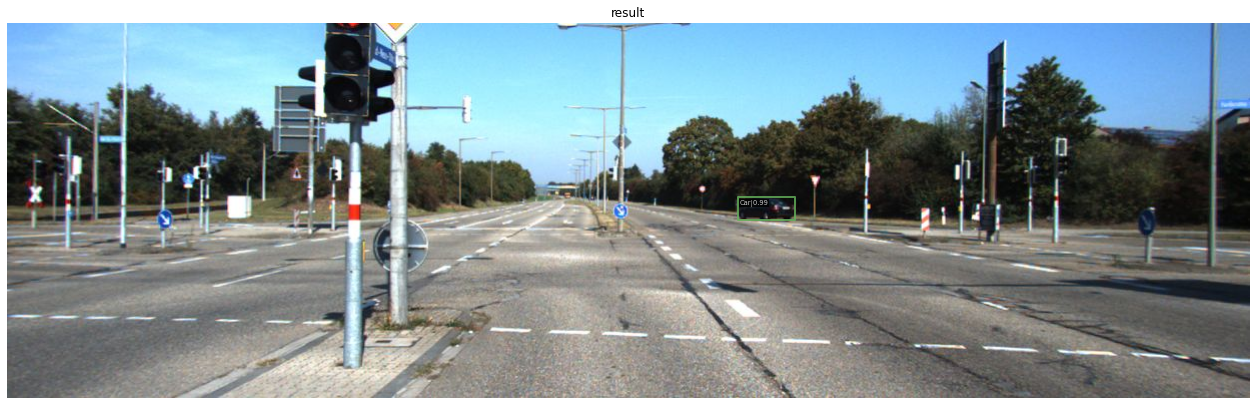

In [36]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# BGR Image 사용 
img = cv2.imread('/content/kitti_tiny/training/image_2/000017.jpeg')

model.cfg = cfg

result = inference_detector(model, img)
show_result_pyplot(model, img, result)

In [37]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# BGR Image 사용 
img = cv2.imread('/content/kitti_tiny/training/image_2/000057.jpeg')

model.cfg = cfg

result = inference_detector(model, img)
show_result_pyplot(model, img, result)